In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My\ Drive/지수/CT
!pwd

Mounted at /content/drive
/content/drive/My Drive/지수/CT
/content/drive/My Drive/지수/CT


In [ ]:
!pip install keras==2.14.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.6 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.17.0 requires keras>=3.2.0, but you have keras 2.14.0 which is incompatible.


In [ ]:
!pip install tensorflow==2.14.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtypes-0.4.0
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 1.2.1
    Uninstalling google-auth-oauthlib-1.2.1:
      Successfully uninstalled google-auth-oauthlib-1.2.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17

In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization

In [ ]:
class JSMA:
    def __init__(self, model, theta=0.2, gamma=0.3, max_iters=100):
        self.model = model
        self.theta = theta
        self.gamma = gamma
        self.max_iters = max_iters

    def saliency_map(self, x, target_class):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(x)
            predictions = self.model(x)
            target_score = predictions[:, target_class]
            other_scores = tf.reduce_sum(predictions, axis=1) - target_score

        gradients = tape.gradient(target_score, x)
        other_gradients = tape.gradient(other_scores, x)

        if gradients is None or other_gradients is None:
            raise ValueError("Gradients computation failed. Ensure the target class and input tensor are correct.")

        S_plus = tf.maximum(0.0, gradients) * tf.maximum(0.0, -other_gradients)
        S_minus = tf.minimum(0.0, gradients) * tf.maximum(0.0, other_gradients)
        return S_plus, S_minus

    def perturb(self, x, target_class):
        x_adv = tf.convert_to_tensor(x, dtype=tf.float32)
        max_iters = min(self.max_iters, int(self.gamma * np.prod(x.shape)))
        iter = 0

        while iter < max_iters:
            S_plus, S_minus = self.saliency_map(x_adv, target_class)

            # NumPy 배열로 변환
            S_plus_np = S_plus.numpy()
            S_minus_np = S_minus.numpy()

            # 최대 살리언시 인덱스 계산
            indices_plus = np.unravel_index(np.argsort(S_plus_np, axis=None)[-2:], S_plus_np.shape)
            indices_minus = np.unravel_index(np.argsort(S_minus_np, axis=None)[-2:], S_minus_np.shape)

            if S_plus_np[indices_plus].sum() >= S_minus_np[indices_minus].sum():
                perturbation = self.theta
                indices = indices_plus
            else:
                perturbation = -self.theta
                indices = indices_minus

            # 인덱스를 텐서로 변환
            indices_tensor = tf.constant([list(idx) for idx in zip(*indices)], dtype=tf.int32)
            updates = tf.constant([perturbation] * len(indices_tensor), dtype=tf.float32)

            # scatter_nd_add 사용
            x_adv = tf.tensor_scatter_nd_add(x_adv, indices_tensor, updates)

            x_adv = tf.clip_by_value(x_adv, 0, 1)

            iter += 1

            if tf.argmax(self.model(x_adv), axis=1)[0] == target_class:
                break

        return x_adv.numpy()

In [ ]:
# 사용 데이터셋에 맞게 사전 훈련된 모델을 로드
model = tf.keras.models.load_model('final_ensemble_model.h5')

# 클래스 이름 매핑(모델의 출력은 numpy 행렬 형식이기 때문에 식별을 위해 명시)
target_names = ["Adenocarcinoma", "Large cell carcinoma", "Normal", "Squamous cell carcinoma"]

In [ ]:
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# 목표 클래스와 epsilon 설정
target_class = 0
epsilon = 45 / 255

# 이미지 크기 설정
target_size = (224, 224)

# 경로 설정
directory = 'Normal/'

# JSMA 공격 클래스 인스턴스 생성
jsma_attack = JSMA(model, theta=0.2, gamma=0.3, max_iters=100)

def process_adversarial_images_and_report(directory, target_class, epsilon, max_images=100):
    total_images = 0
    successful_attacks = 0
    total_time = 0
    total_pixel_changes = 0
    total_l2_norm = 0  # L2 노름을 저장할 변수 추가

    for filename in os.listdir(directory):
        if filename.endswith('.png'):  # 필요한 파일 형식에 맞게 수정
            total_images += 1
            if total_images > max_images:  # 이미지 100개로 제한
                break

            # 이미지 로드
            image_path = os.path.join(directory, filename)
            image = load_img(image_path, target_size=target_size)
            image = img_to_array(image) / 255.0
            image = np.expand_dims(image, axis=0)  # 배치 차원 추가

            # 공격 전 이미지 저장
            original_image = np.copy(image)

            # 공격 시작 시간 기록
            start_time = time.time()

            # 적대적 이미지 생성
            adversarial_image = jsma_attack.perturb(image, target_class)

            # 공격 후 시간 기록
            end_time = time.time()
            total_time += (end_time - start_time)

            # 예측 클래스 확인
            prediction = model.predict(adversarial_image)
            predicted_class = np.argmax(prediction, axis=1)

            # 공격 성공 여부 확인
            if predicted_class == target_class:
                successful_attacks += 1
                print("attack success")

            # L0 norm 계산 (변화한 픽셀 수)
            original_image_flat = np.round(original_image.flatten() * 255)
            adversarial_image_flat = np.round(adversarial_image.flatten() * 255)
            pixel_changes = np.sum(original_image_flat != adversarial_image_flat)
            total_pixel_changes += pixel_changes

            # L2 norm 계산
            l2_norm = np.linalg.norm(original_image - adversarial_image)
            total_l2_norm += l2_norm

    # 공격 성공률 계산
    attack_success_rate = (successful_attacks / total_images) * 100
    # 평균 L0 norm 계산
    average_l0_norm = total_pixel_changes / total_images
    # 평균 L2 norm 계산
    average_l2_norm = total_l2_norm / total_images
    # 평균 공격 속도 계산
    average_attack_speed = total_time / total_images

    # 결과 출력
    print(f"총 이미지 수: {total_images}")
    print(f"성공한 공격 수: {successful_attacks}")
    print(f"공격 성공률: {attack_success_rate:.2f}%")
    print(f"평균 L0 norm (변화한 픽셀 수): {average_l0_norm:.2f}")
    print(f"평균 L2 norm: {average_l2_norm:.4f}")
    print(f"평균 공격 속도 (초): {average_attack_speed:.4f} 초")

# 적대적 이미지 생성 및 결과 보고
process_adversarial_images_and_report(directory, target_class, epsilon, max_images=100)


1/1 [==============================] - 0s 415ms/step
attack success
1/1 [==============================] - 1s 635ms/step
attack success
1/1 [==============================] - 0s 368ms/step
attack success
1/1 [==============================] - 1s 639ms/step
attack success
1/1 [==============================] - 0s 374ms/step
attack success
1/1 [==============================] - 1s 644ms/step
attack success
1/1 [==============================] - 0s 388ms/step
attack success
1/1 [==============================] - 1s 634ms/step
attack success
1/1 [==============================] - 0s 368ms/step
attack success
1/1 [==============================] - 1s 653ms/step
attack success
1/1 [==============================] - 0s 378ms/step
attack success
1/1 [==============================] - 0s 369ms/step
attack success
1/1 [==============================] - 0s 381ms/step
attack success
1/1 [==============================] - 0s 374ms/step
attack success
1/1 [==============================] - 0s 393ms/

1/1 [==============================] - 7s 7s/step


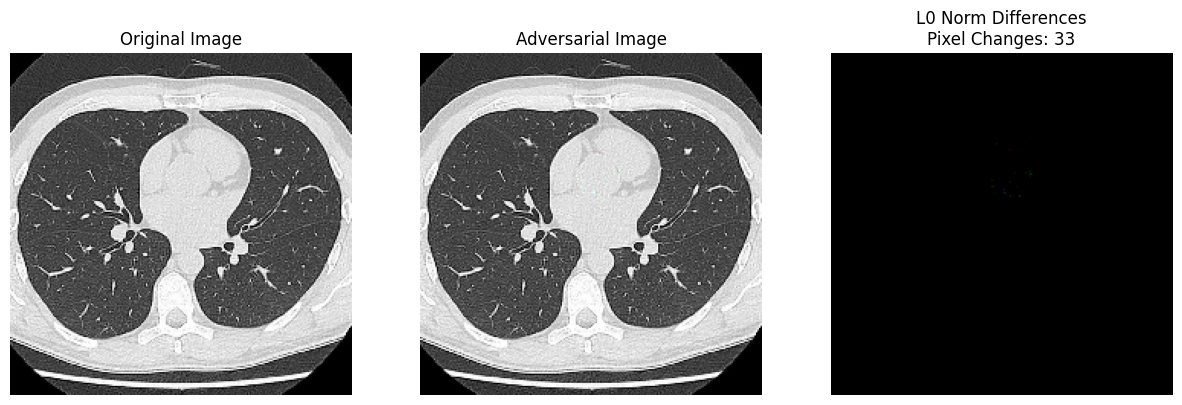

1/1 [==============================] - 0s 397ms/step


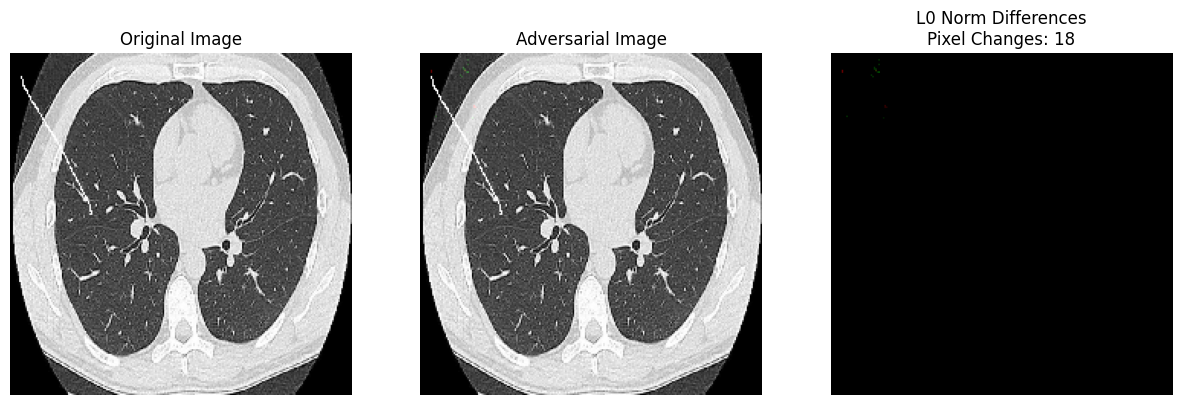

1/1 [==============================] - 0s 389ms/step


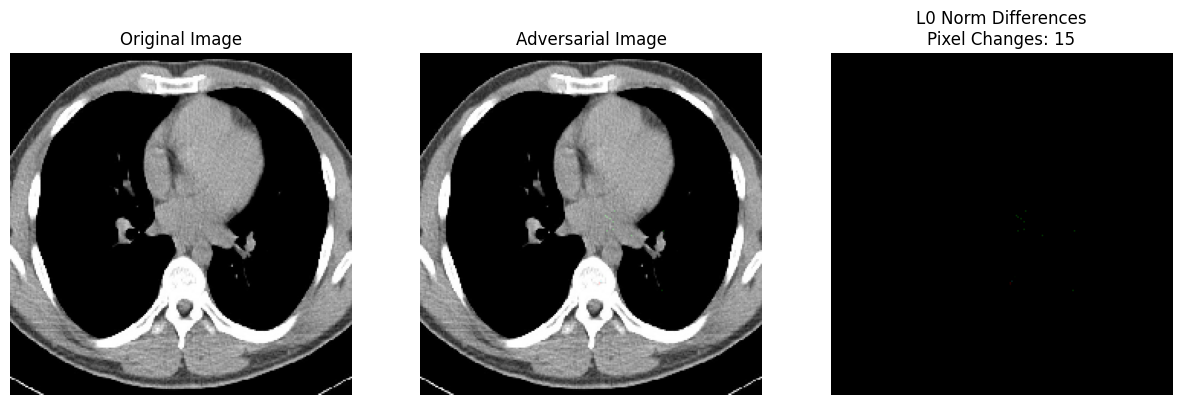

총 이미지 수: 4
성공한 공격 수: 0
공격 성공률: 0.00%
평균 L0 norm (변화한 픽셀 수): 16.5
평균 공격 속도 (초): 528.3093 초


In [ ]:
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# 목표 클래스와 epsilon 설정
target_class = 1
epsilon = 45 / 255

# 이미지 크기 설정
target_size = (224, 224)

# 경로 설정
directory = 'Normal/'

# JSMA 공격 클래스 인스턴스 생성
jsma_attack = JSMA(model, theta=0.2, gamma=0.3, max_iters=100)


def process_adversarial_images_and_report(directory, target_class, epsilon, max_images=3):
    total_images = 0
    successful_attacks = 0
    total_time = 0
    total_pixel_changes = 0

    for filename in os.listdir(directory):
        if filename.endswith('.png'):  # 필요한 파일 형식에 맞게 수정
            total_images += 1
            if total_images > max_images:  # 세 개의 이미지로 제한
                break
            # 이미지 로드
            image_path = os.path.join(directory, filename)
            image = load_img(image_path, target_size=target_size)
            image = img_to_array(image) / 255.0
            image = np.expand_dims(image, axis=0)  # 배치 차원 추가

            # 공격 전 이미지 저장
            original_image = np.copy(image)

            # 공격 시작 시간 기록
            start_time = time.time()

            # 적대적 이미지 생성
            adversarial_image = jsma_attack.perturb(image, target_class)

            # 공격 후 시간 기록
            end_time = time.time()
            total_time += (end_time - start_time)

            # 예측 클래스 확인
            prediction = model.predict(adversarial_image)
            predicted_class = np.argmax(prediction, axis=1)

            # 공격 성공 여부 확인
            if predicted_class == target_class:
                successful_attacks += 1

            # L0 norm 계산 (변화한 픽셀 수)
            original_image_flat = np.round(original_image.flatten() * 255)
            adversarial_image_flat = np.round(adversarial_image.flatten() * 255)
            pixel_changes = np.sum(original_image_flat != adversarial_image_flat)
            total_pixel_changes += pixel_changes

            # 이미지 시각화
            visualize_images(original_image, adversarial_image, pixel_changes)

    # 공격 성공률 계산
    attack_success_rate = (successful_attacks / total_images) * 100
    # 평균 L0 norm 계산
    average_l0_norm = total_pixel_changes / total_images
    # 평균 공격 속도 계산
    average_attack_speed = total_time / total_images

    # 결과 출력
    print(f"총 이미지 수: {total_images}")
    print(f"성공한 공격 수: {successful_attacks}")
    print(f"공격 성공률: {attack_success_rate:.2f}%")
    print(f"평균 L0 norm (변화한 픽셀 수): {average_l0_norm}")
    print(f"평균 공격 속도 (초): {average_attack_speed:.4f} 초")

def visualize_images(original_image, adversarial_image, pixel_changes):
    # 이미지를 시각화
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # 원본 이미지
    axs[0].imshow(original_image[0])
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    # 적대적 이미지
    axs[1].imshow(adversarial_image[0])
    axs[1].set_title('Adversarial Image')
    axs[1].axis('off')

    # L0 norm 비교 이미지
    diff_image = np.abs(original_image - adversarial_image)
    axs[2].imshow(diff_image[0])
    axs[2].set_title(f'L0 Norm Differences\nPixel Changes: {pixel_changes}')
    axs[2].axis('off')

    plt.show()

# 적대적 이미지 생성 및 결과 보고
process_adversarial_images_and_report(directory, target_class, epsilon)


1/1 [==============================] - 7s 7s/step


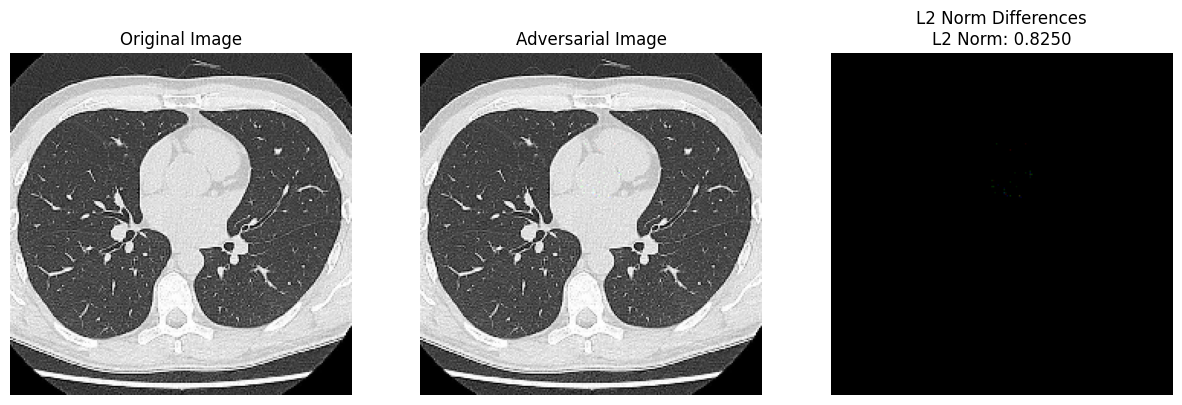

1/1 [==============================] - 0s 411ms/step


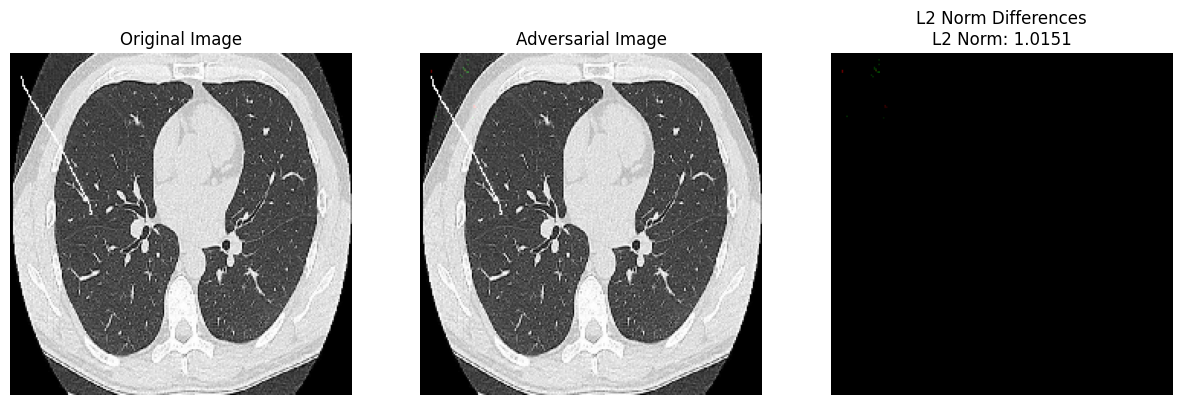

1/1 [==============================] - 0s 375ms/step


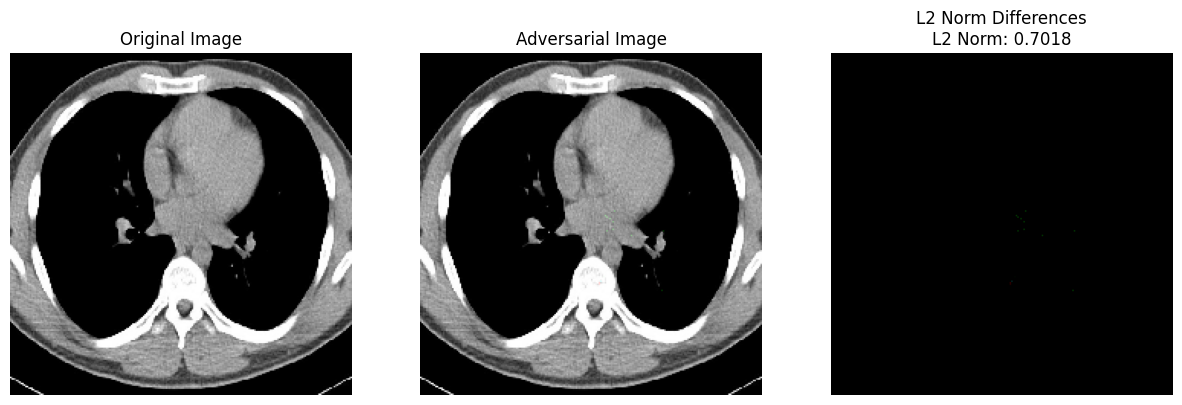

총 이미지 수: 4
성공한 공격 수: 0
공격 성공률: 0.00%
평균 L2 norm: 0.6355
평균 공격 속도 (초): 506.8820 초


In [ ]:
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# 목표 클래스와 epsilon 설정
target_class = 1
epsilon = 45 / 255

# 이미지 크기 설정
target_size = (224, 224)

# 경로 설정
directory = 'Normal/'

# JSMA 공격 클래스 인스턴스 생성
jsma_attack = JSMA(model, theta=0.2, gamma=0.3, max_iters=100)

def process_adversarial_images_and_report(directory, target_class, epsilon, max_images=3):
    total_images = 0
    successful_attacks = 0
    total_time = 0
    total_pixel_changes = 0
    total_l2_norm = 0  # L2 노름을 저장할 변수 추가

    for filename in os.listdir(directory):
        if filename.endswith('.png'):  # 필요한 파일 형식에 맞게 수정
            total_images += 1
            if total_images > max_images:  # 세 개의 이미지로 제한
                break
            # 이미지 로드
            image_path = os.path.join(directory, filename)
            image = load_img(image_path, target_size=target_size)
            image = img_to_array(image) / 255.0
            image = np.expand_dims(image, axis=0)  # 배치 차원 추가

            # 공격 전 이미지 저장
            original_image = np.copy(image)

            # 공격 시작 시간 기록
            start_time = time.time()

            # 적대적 이미지 생성
            adversarial_image = jsma_attack.perturb(image, target_class)

            # 공격 후 시간 기록
            end_time = time.time()
            total_time += (end_time - start_time)

            # 예측 클래스 확인
            prediction = model.predict(adversarial_image)
            predicted_class = np.argmax(prediction, axis=1)

            # 공격 성공 여부 확인
            if predicted_class == target_class:
                successful_attacks += 1

            # L2 norm 계산
            l2_norm = np.linalg.norm(original_image - adversarial_image)
            total_l2_norm += l2_norm

            # 이미지 시각화
            visualize_images(original_image, adversarial_image, l2_norm)

    # 공격 성공률 계산
    attack_success_rate = (successful_attacks / total_images) * 100
    # 평균 L2 norm 계산
    average_l2_norm = total_l2_norm / total_images
    # 평균 공격 속도 계산
    average_attack_speed = total_time / total_images

    # 결과 출력
    print(f"총 이미지 수: {total_images}")
    print(f"성공한 공격 수: {successful_attacks}")
    print(f"공격 성공률: {attack_success_rate:.2f}%")
    print(f"평균 L2 norm: {average_l2_norm:.4f}")
    print(f"평균 공격 속도 (초): {average_attack_speed:.4f} 초")

def visualize_images(original_image, adversarial_image, l2_norm):
    # 이미지를 시각화
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # 원본 이미지
    axs[0].imshow(original_image[0])
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    # 적대적 이미지
    axs[1].imshow(adversarial_image[0])
    axs[1].set_title('Adversarial Image')
    axs[1].axis('off')

    # L2 norm 비교 이미지
    diff_image = np.abs(original_image - adversarial_image)
    axs[2].imshow(diff_image[0])
    axs[2].set_title(f'L2 Norm Differences\nL2 Norm: {l2_norm:.4f}')
    axs[2].axis('off')

    plt.show()

# 적대적 이미지 생성 및 결과 보고
process_adversarial_images_and_report(directory, target_class, epsilon)
